In [39]:
import pandas as pd
import model_utils as mu
import torch
import numpy as np
from sklearn.cluster import KMeans  # Correct
import random

from sentence_transformers import SentenceTransformer
EMBEDDINGS_SIZE = 50
NUM_SEQUENCES_PER_BATCH = 128

In [ ]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

In [2]:
#load the data, tuples
similar_song_lyrics= pd.read_csv("data/similar_song_lyrics_2.csv") 
print(len( similar_song_lyrics))


504


In [3]:
#Grab the lyrics and the corresponding similar song title
lyrics, similar_song_title = similar_song_lyrics["lyrics"].tolist(), similar_song_lyrics["similar_track"].tolist()
processed_lyrics = []
for lyric in lyrics:
    processed_lyrics.append(mu.preprocess_sentence(lyric))

In [12]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [13]:
sentence_embeddings = sentence_model.encode(processed_lyrics, batch_size=NUM_SEQUENCES_PER_BATCH, convert_to_tensor=True)
sentence_embeddings = sentence_embeddings.to(device)

In [15]:
sentence_embeddings = sentence_embeddings.cpu().numpy()


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sentence_embeddings_scaled = scaler.fit_transform(sentence_embeddings)

In [31]:

#initalize the model
kmeans = KMeans(n_clusters=3,init='k-means++',max_iter=3000,n_init=1,random_state=0)

#fit the model to a line
model = kmeans.fit(sentence_embeddings)

predicted_values = model.predict(sentence_embeddings)

print(predicted_values)

[1 1 0 0 0 2 2 2 2 1 0 2 2 1 2 0 0 1 0 1 0 0 2 2 0 1 2 0 2 1 0 1 0 2 2 2 0
 0 0 2 1 0 1 1 2 2 2 1 2 2 2 0 2 2 2 2 0 2 2 1 0 1 0 2 1 2 2 2 2 1 0 2 2 1
 0 2 2 1 2 1 2 2 2 0 1 2 0 2 2 2 2 0 2 1 1 2 0 1 2 1 1 2 2 0 2 0 2 1 1 2 2
 2 1 2 1 0 2 2 2 0 2 1 2 1 1 2 1 0 1 2 2 2 1 2 2 2 2 0 2 2 0 2 2 1 2 2 2 0
 0 2 1 0 2 1 2 2 1 2 1 1 2 1 2 2 1 1 1 0 1 2 0 1 1 2 2 0 2 1 0 0 0 2 0 0 2
 2 1 1 0 1 0 0 1 1 1 2 2 2 1 2 0 0 2 2 2 0 2 0 0 0 1 0 2 2 2 2 2 2 1 1 1 0
 2 1 1 2 1 1 0 0 1 1 2 1 0 0 1 2 0 0 0 2 1 2 0 2 1 0 1 0 1 0 1 2 0 1 0 0 0
 1 1 1 1 1 2 1 1 0 2 2 1 1 2 0 2 2 2 2 2 0 1 2 0 2 2 2 0 0 1 1 0 1 1 2 1 2
 2 2 2 2 2 1 2 0 1 0 2 2 1 0 2 0 0 1 1 0 0 0 0 0 0 0 1 2 1 0 2 0 2 2 2 2 0
 0 0 0 0 0 0 2 0 0 0 2 2 1 0 2 2 2 1 2 0 2 0 0 1 0 1 0 2 1 1 1 2 1 2 2 1 2
 1 1 0 2 2 2 0 1 2 1 1 2 1 1 1 2 1 2 1 0 1 2 2 0 0 1 0 0 1 2 0 0 0 1 2 0 2
 0 0 1 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 1 2 2 0 0 0 1 2 2 0 0 0 0 0 0 1
 2 2 1 2 0 0 2 1 0 0 2 0 1 0 1 0 2 0 2 1 0 2 0 1 2 0 2 0 2 2 2 2 0 2 2 0 0
 0 0 0 1 1 1 1 1 0 2 1 0 

In [92]:
def pick_random_song_from_cluster(cluster_id, songs, predicted_values):
    # Get the indices of all songs in the given cluster
    cluster_indices = np.where(predicted_values == cluster_id)[0]
    
    if len(cluster_indices) == 0:
        print(f"No songs found in cluster {cluster_id}")
        return None
    
    # Choose a random index from the cluster
    random_index = random.choice(cluster_indices)
    
    # Return the corresponding song info
    return songs.iloc[random_index]

# Example usage: pick a random song from cluster 1
random_song = pick_random_song_from_cluster(1, similar_song_lyrics["similar_track"], predicted_values)
print(random_song)

98 Freestyle


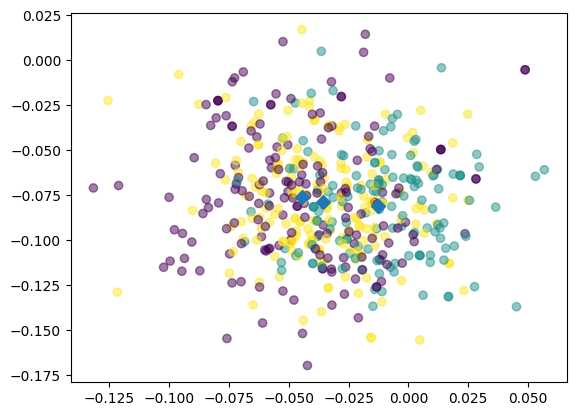

In [34]:
# Determine the cluster labels of new_points: labels
labels = kmeans.predict(sentence_embeddings)
# Import pyplot
import matplotlib.pyplot as plt
# Assign the columns of new_points: xs and ys
xs = sentence_embeddings[:,0]
ys = sentence_embeddings[:,1]
# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(xs,ys,c=labels,alpha=0.5)
# Assign the cluster centers: centroids
centroids = model.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()